/Users/andrewbrettin/Desktop/class/data_science/Project/HurricaneProject/utils.py:69: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes(projection=projection)


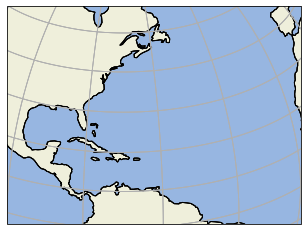

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import csv
from sklearn.preprocessing import StandardScaler

import datetime
import cartopy
import cartopy.crs as ccrs
import cftime

import utils

## Data preparation

In [2]:
# Takes in a file of data and searches for row headers (i.e. the rows that correspond to a unique hurricane).
# Returns the data as a dataframe, with the row header ID as the first column.
def clean_file(filename):
    
    f = open(filename, mode='r')
    reader = csv.reader(f)
    header = []
    data = [] # 2d list to hold all the data
    for row in reader:
        if row[0].startswith("AL"): # Header row
            header = row[0]
        else:
            row.insert(0, header)# append ID to row
            data.append(row[:-1]) # don't know why theres an extra empty column
    f.close()
    df = pd.DataFrame(data, columns=['ID','Date', 'Time', 'Record', 'Status', 'Latitude', 'Longitude',
                               'Wind speed','Pressure','34NE','34SE','34SW','34NW',
                               '50NE','50SE','50SW','50NW','64NE','64SE','64SW','64NW'])
    df['Date'] = df['Date'].apply(utils.convert_time)
    
    df['Latitude'] = df['Latitude'].apply(utils.convert_coords)
    df['Longitude'] = df['Longitude'].apply(utils.convert_coords)
    return df

In [3]:
df = clean_file('hurdat2.txt')
# df = prep_hurricane_data(df)
df

,ID,Date,Time,Record,Status,Latitude,Longitude,Wind speed,Pressure,34NE,...,34SW,34NW,50NE,50SE,50SW,50NW,64NE,64SE,64SW,64NW
0,AL011851,1851-06-25 00:00:00,0000,,HU,28.0,-94.8,80,-999,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
1,AL011851,1851-06-25 00:00:00,0600,,HU,28.0,-95.4,80,-999,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
2,AL011851,1851-06-25 00:00:00,1200,,HU,28.0,-96.0,80,-999,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
3,AL011851,1851-06-25 00:00:00,1800,,HU,28.1,-96.5,80,-999,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
4,AL011851,1851-06-25 00:00:00,2100,L,HU,28.2,-96.8,80,-999,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51835,AL202019,2019-11-26 00:00:00,1200,,EX,52.2,-9.3,45,970,90,...,120,90,0,0,0,0,0,0,0,0
51836,AL202019,2019-11-26 00:00:00,1800,,EX,52.2,-8.9,40,972,90,...,90,90,0,0,0,0,0,0,0,0
51837,AL202019,2019-11-27 00:00:00,0000,,EX,51.8,-8.2,40,974,0,...,90,0,0,0,0,0,0,0,0,0
51838,AL202019,2019-11-27 00:00:00,0600,,EX,51.4,-6.0,40,976,0,...,90,0,0,0,0,0,0,0,0,0


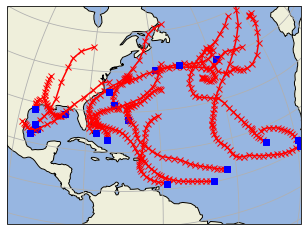

In [4]:
hurricane_IDs = df['ID'].unique()
ax = utils.create_geoaxes()

for ID in hurricane_IDs[-20:-1]:
    utils.plot_hurricane_trajectory(df, ID, ax=ax)

In [14]:
# Create dataframe of each individual hurricane
hurricane_IDs = df['ID'].unique()
hurricane_df = pd.DataFrame.from_dict({'ID':hurricane_IDs})
columns = ['Duration', 'Initial latitude', 'Initial longitude', 'Initial wind speed', 'Initial pressure',
           'Makes landfall', 'Landfall latitude', 'Landfall longitude']
hurricane_df = hurricane_df.set_index(['ID'])

# Set hurricane data columns
for col in columns:
    hurricane_df[col] = None

for ID in hurricane_IDs:
    attrs = utils.get_hurricane_attributes(df, ID)
    for col in attrs:
        hurricane_df.at[ID, col] = attrs[col]

hurricane_df['Initial latitude'] = hurricane_df['Initial latitude'].astype('float')
hurricane_df['Initial longitude'] = hurricane_df['Initial longitude'].astype('float')
hurricane_df['Initial wind speed'] = hurricane_df['Initial wind speed'].astype('int')
hurricane_df['Initial pressure'] = hurricane_df['Initial pressure'].astype('int')
hurricane_df['Makes landfall'] = hurricane_df['Makes landfall'].astype('int')

In [15]:
# Get rid of outlier landfall positions (anything east of 40W)
hurricane_df = hurricane_df[(hurricane_df['Landfall longitude'] < -40) | (hurricane_df['Landfall longitude'].isnull())]

In [16]:
hurricane_df

,Duration,Initial latitude,Initial longitude,Initial wind speed,Initial pressure,Makes landfall,Landfall latitude,Landfall longitude
ID,,,,,,,,
AL011851,14,28.0,-94.8,80,-999,1,28.2,-96.8
AL021851,1,22.2,-97.6,80,-999,0,NaN,NaN
AL031851,1,12.0,-60.0,50,-999,0,NaN,NaN
AL041851,49,13.4,-48.0,40,-999,1,30.1,-85.7
AL051851,16,32.5,-73.5,50,-999,0,NaN,NaN
...,...,...,...,...,...,...,...,...
AL162019,15,22.2,-95.7,35,1007,0,NaN,NaN
AL172019,10,24.7,-94.8,35,1004,0,NaN,NaN
AL182019,22,40.0,-38.3,40,1000,0,NaN,NaN


## K means clustering

Due to the convergence of meridians, we rescale latitude and longitude according to the latitude of the genesis point. Let $\theta$, $\phi$ be the latitude and longitude, respectively. Then
$$ y = \theta \sin \theta $$
$$ x = \phi \sin \theta$$
provide scaling so that the metric $d((x_1, y_1) , (x_2, y_2)) = \sqrt{(x_1 - x_2)^2 + (y_1 - y_2)^2}$

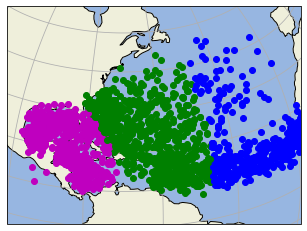

In [17]:
from sklearn.cluster import KMeans
import numpy as np
k = 3
X = hurricane_df[['Initial latitude', 'Initial longitude']]
X = np.array(hurricane_df[['Initial latitude', 'Initial longitude']], dtype=float)
X[:,1] = X[:,1]*np.cos(X[:,0]/360*2*np.pi)
X[:,0] = X[:,0]#*np.cos(X[:,0]/360*2*np.pi)
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)
kmeans.labels_

# hurricane_df['Cluster'] = kmeans.predict(hurricane_df[['Initial latitude','Initial longitude']])
hurricane_df['Cluster'] = kmeans.predict(X)
hurricane_df
colors = [(np.random.rand(3), np.random.rand(3), np.random.rand(3)) for i in range(k)]
ax = utils.create_geoaxes()
for ID in hurricane_df.index:
    if hurricane_df.loc[ID]['Cluster'] == 0:
        color = 'g'
    elif hurricane_df.loc[ID]['Cluster'] == 1:
        color = 'm'
    else: #hurricane_df.loc[ID]['Cluster'] == 2:
        color = 'b'
    lat = hurricane_df.loc[ID]['Initial latitude']
    lon = hurricane_df.loc[ID]['Initial longitude']
    ax.plot([lon], [lat], color=color, marker='o', transform=ccrs.PlateCarree())

In [18]:
for i in range(3):
    cluster_i = hurricane_df[hurricane_df['Cluster'] == i]
    print(sum(cluster_i['Makes landfall'])/len(cluster_i))

0.2529335071707953
0.5699404761904762
0.14317673378076062


This doesn't incorporate the heavier spread in longitude than in latitudes, so we normalize these columns by the standard deviations:

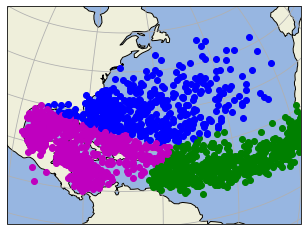

In [31]:
k = 3
X = hurricane_df[['Initial latitude', 'Initial longitude']]
X = np.array(hurricane_df[['Initial latitude', 'Initial longitude']], dtype=float)
X[:,1] = X[:,1]*np.cos(X[:,0]/360*2*np.pi)
X[:,0] = X[:,0]#*np.cos(X[:,0]/360*2*np.pi)

X[:,1] = X[:,1]/np.std(X[:,1])

X[:,0] = X[:,0]/np.std(X[:,0])

kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
kmeans.labels_

# hurricane_df['Cluster'] = kmeans.predict(hurricane_df[['Initial latitude','Initial longitude']])
hurricane_df['Cluster'] = kmeans.predict(X)
hurricane_df
colors = ['g', 'm', 'b', 'r', 'k']
ax = utils.create_geoaxes()
for ID in hurricane_df.index:
    color = colors[hurricane_df.loc[ID]['Cluster']]
    lat = hurricane_df.loc[ID]['Initial latitude']
    lon = hurricane_df.loc[ID]['Initial longitude']
    ax.plot([lon], [lat], color=color, marker='o', transform=ccrs.PlateCarree())

In [32]:
for i in range(k):
    cluster_i = hurricane_df[hurricane_df['Cluster'] == i]
    print(sum(cluster_i['Makes landfall'])/len(cluster_i))

0.23557692307692307
0.5280612244897959
0.16736401673640167


In [21]:
# Plotting landfall lat:
landfalls = hurricane_df[hurricane_df['Makes landfall'] == 1]

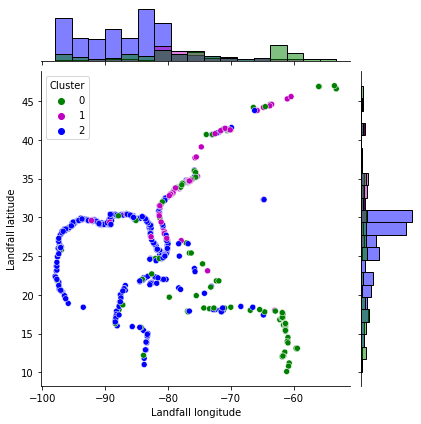

In [22]:
grid = sns.JointGrid(data=landfalls, x="Landfall longitude", y="Landfall latitude",
                     hue='Cluster', palette=colors[0:3])
jointplot = grid.plot_joint(sns.scatterplot)
grid.plot_marginals(sns.histplot)

## Predicting landfall probability based on cluster

In [24]:
from sklearn import metrics
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

In [47]:
hurricane_df
hurricane_df_c0 = hurricane_df[hurricane_df['Cluster'] == 0]
hurricane_df_c1 = hurricane_df[hurricane_df['Cluster'] == 1]
hurricane_df_c2 = hurricane_df[hurricane_df['Cluster'] == 2]

X = hurricane_df_c0[['Initial latitude', 'Initial longitude']]
Y = hurricane_df_c0['Makes landfall']

kfolds = KFold(n_splits = 4)

#1st, set up a paramater grid
param_grid_lr = {'C':[10**i for i in range(-3, 2)]}

#2nd, call the GridSearchCV class, use LogisticRegression and 'roc_auc' for scoring
lr_grid_search = GridSearchCV(LogisticRegression(), param_grid_lr, cv = kfolds, scoring = 'roc_auc') 
lr_grid_search.fit(X, Y)

#3rd, get the score of the best model and print it
lr_grid_search.best_estimator_

LogisticRegression(C=0.01)

In [43]:
# Dataframe with information about the wind speed and pressure
hurricane_df2 = hurricane_df[(hurricane_df['Initial pressure'] != -999) & (hurricane_df['Initial wind speed'] != -999)]

In [44]:
hurricane_df2_c0 = hurricane_df2[hurricane_df2['Cluster'] == 0]
hurricane_df2_c1 = hurricane_df2[hurricane_df2['Cluster'] == 1]
hurricane_df2_c2 = hurricane_df2[hurricane_df2['Cluster'] == 2]

X = hurricane_df2_c2[['Initial latitude', 'Initial longitude', 'Initial wind speed', 'Initial pressure']]
Y = hurricane_df2_c2['Makes landfall']

#1st, set up a paramater grid
param_grid_lr = {'C':[10**i for i in range(-2, 2)]}

#2nd, call the GridSearchCV class, use LogisticRegression and 'roc_auc' for scoring
lr_grid_search = GridSearchCV(LogisticRegression(), param_grid_lr, cv = kfolds, scoring = 'roc_auc') 
lr_grid_search.fit(X, Y)

#3rd, get the score of the best model and print it
best_1 = lr_grid_search.best_score_
print(best_1)

0.8329081554410502
